Required: Dockerfile, .env, docker-compose.yml

Pull the gcfntnu/scanpy image from Docker Hub\
`docker pull gcfntnu/scanpy`

Tag the pulled image with the local name jupyter-notebook-env\
`docker tag gcfntnu/scanpy jupyter-notebook-env`

Verify that the image has been tagged correctly by listing Docker images\
`docker images`

Build the Docker image with the updated Dockerfile\
`docker build -t jupyter-notebook-env .`

Run the Docker container with the necessary volume mounts and port mappings\
`docker-compose up`

In [1]:
import os
import paramiko
from scp import SCPClient

def create_ssh_client(hostname, port, username, password):
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    if password:
        ssh.connect(hostname, port=port, username=username, password=password)
    else:
        ssh.connect(hostname, port=port, username=username)
    return ssh

def copy_files_from_remote(ssh, remote_directory, local_directory):
    with SCPClient(ssh.get_transport()) as scp:
        scp.get(remote_directory, local_path=local_directory, recursive=True)

# Access environment variables
hostname = os.getenv('SSH_HOSTNAME')
username = os.getenv('SSH_USERNAME')
password = os.getenv('SSH_PASSWORD') 
port = os.getenv('SSH_PORT')
remote_directory = os.getenv('REMOTE_DIRECTORY')
local_directory = '/workspace/data' 

try:
    ssh = create_ssh_client(hostname, port, username, password)
    print("SSH session established")

    # Copy files from remote to local
    copy_files_from_remote(ssh, remote_directory, local_directory)
    print("Files copied successfully")

except Exception as e:
    print(f"Error connecting or copying files: {e}")

finally:
    ssh.close()
    print("SSH session closed")

SSH session established
Files copied successfully
SSH session closed


In [2]:
import pandas as pd  # Importing pandas for data manipulation
import scanpy as sc  # Importing scanpy for single-cell analysis

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
# Set verbosity level to 4 for detailed progress for debugging
sc.settings.verbosity = 4  # verbosity: errors (0), warnings (1), info (2), hints (3), debug (4)

# Print a header indicating the Scanpy version and time of execution
sc.logging.print_header() # Versions that might influence the numerical results

# Set figure parameters for visualizations in Scanpy
sc.set_figure_params(dpi = 80, facecolor = "white") # dpi: resolution of rendered figures, facecolor: backgrounds

2024-07-08 07:05:57.177388: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


scanpy==1.10.1 anndata==0.10.7 umap==0.5.5 numpy==1.23.5 scipy==1.10.1 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.5 louvain==0.8.2 pynndescent==0.5.12


In [4]:
# Define the path to the file where the analysis results will be stored
results_file = "write/GSM7802682.h5ad"  # the file that will store the analysis results

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(results_file), exist_ok=True)

In [5]:
# Read the 10x mtx file
adata = sc.read_10x_mtx(
    "/workspace/data/",  # Provide the directory path containing the `.mtx` file
    cache = True,  # Write a cache file for faster subsequent reading
    prefix = "GSM7802682_C46_SC_3pr_"
)

    reading /workspace/data/GSM7802682_C46_SC_3pr_matrix.mtx.gz
... writing an h5ad cache file to speedup reading next time


In [6]:
# This is unnecessary if using 'var_names="gene_ids"' because the gene IDs are already unique
# It ensures that each gene is represented by a unique identifier in the Anndata object
adata.var_names_make_unique()

In [7]:
# Display the Anndata object
adata

AnnData object with n_obs × n_vars = 737280 × 33538
    var: 'gene_ids', 'feature_types'

## Preprocessing

normalizing counts per cell


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:233: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


    finished (0:00:00)


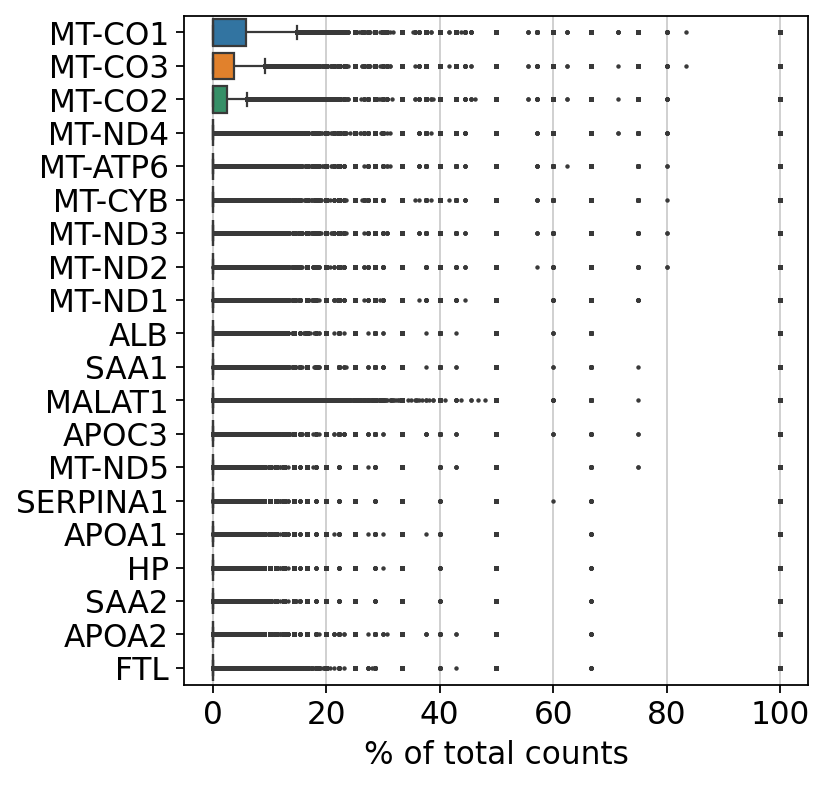

In [8]:
# Visualize top expressing genes
sc.pl.highest_expr_genes(adata, n_top=20)

Mitochondrial Genes: Many of the top expressing genes (MT-CO1, MT-CO3, MT-CO2, MT-ND4, MT-ATP6, etc.) are mitochondrial genes, indicated by the "MT-" prefix. This is common in single-cell RNA-seq data.\
Variability: Some genes (e.g., MT-CO1) show high expression with relatively low variability across cells, while others (e.g., FTL) show more variable expression patterns.\
Non-mitochondrial Genes: Several non-mitochondrial genes also appear in the top 20, such as ALB, SAA1, MALAT1, and SERPINA1, which may be indicative of the cell types or conditions in the sample.

In [9]:
# Filter cells with low gene count
sc.pp.filter_cells(adata, min_genes=200)

# Filter genes with low cell count
sc.pp.filter_genes(adata, min_cells=3)

filtered out 676061 cells that have less than 200 genes expressed
filtered out 13674 genes that are detected in less than 3 cells


In [10]:
# Annotate mitochondrial genes as "MT" for QC
# High proportions of mitochondrial genes are indicative of poor-quality cells
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# Calculate QC metrics
sc.pp.calculate_qc_metrics(
    adata, qc_vars = ["mt"], percent_top = None, log1p = False, inplace = True
)

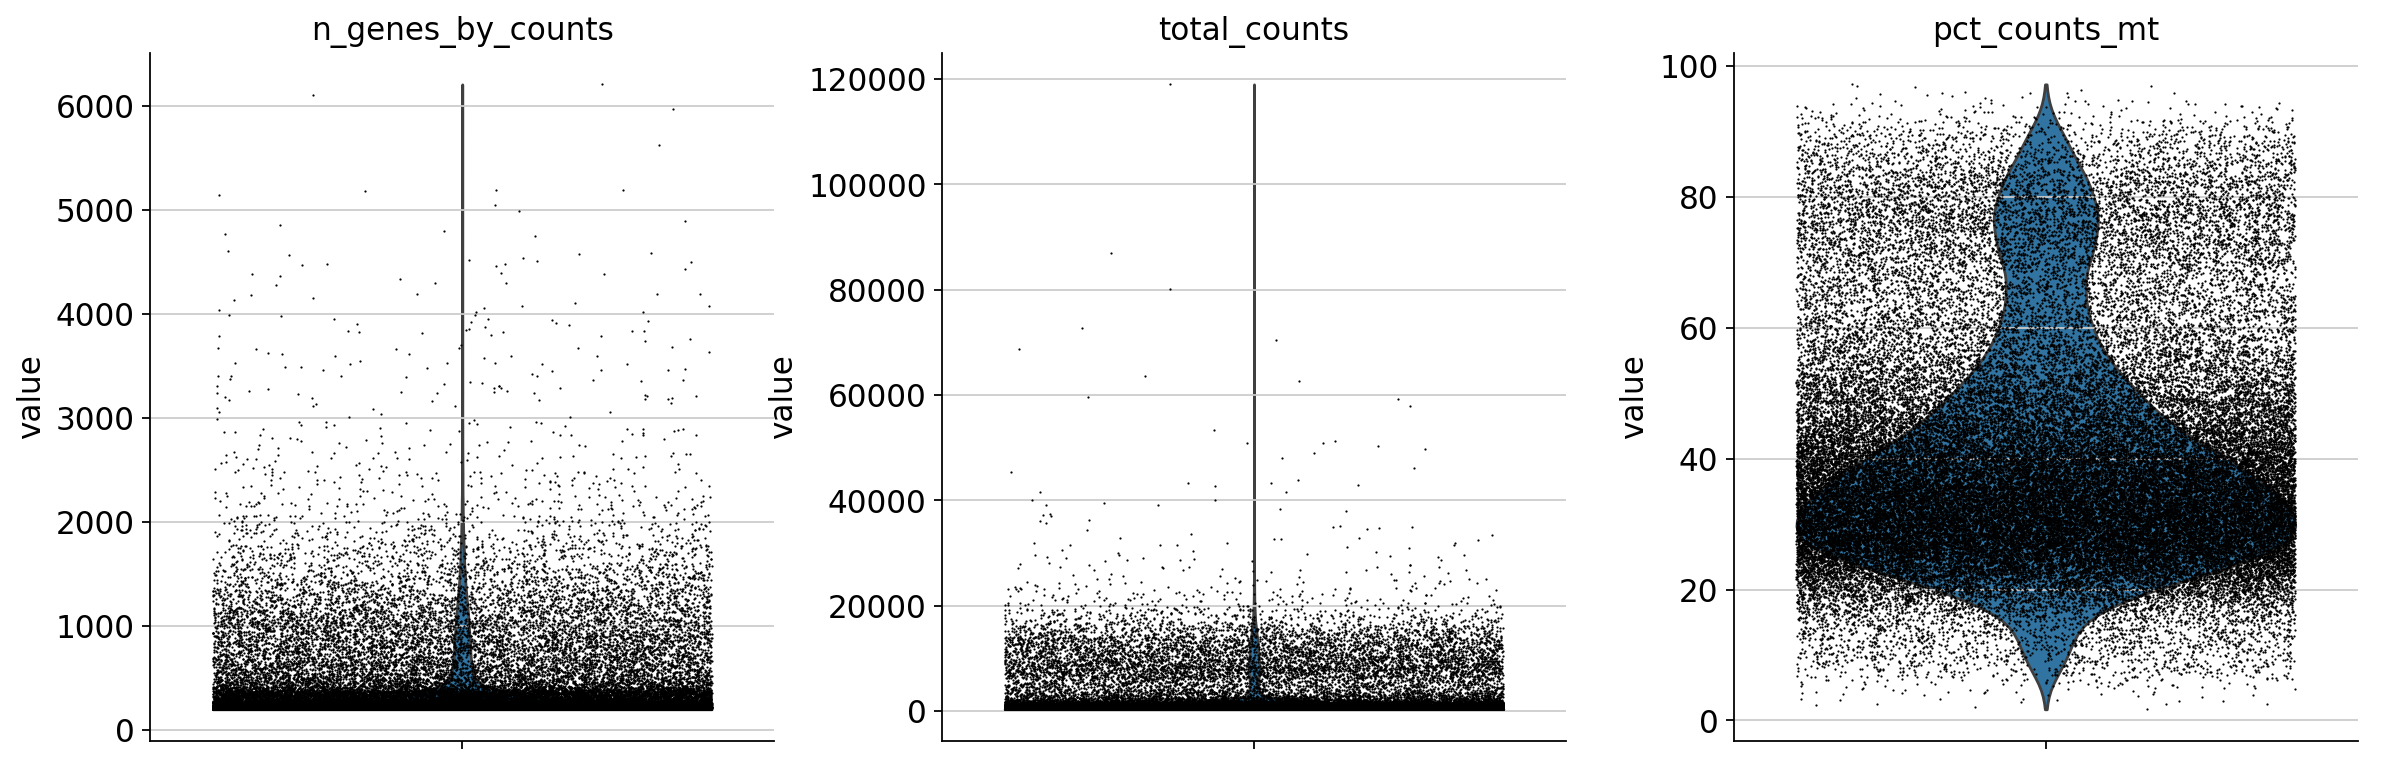

In [11]:
# Plot violin plots for key metrics:
# number of genes expressed in the count matrix,
# total counts per cell,
# percentage of counts in mitochondrial genes
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

n_genes_by_counts: Shows the distribution of the number of genes detected per cell. Most cells have between 0-2000 genes detected, with some outliers having up to 6000.\
total_counts: Displays the distribution of total RNA counts per cell. The majority of cells have less than 20,000 counts, with some reaching up to 100,000.\
pct_counts_mt: Represents the percentage of counts from mitochondrial genes. There's a wide distribution, with most cells having 20-60% mitochondrial content, but some reaching up to 100%.

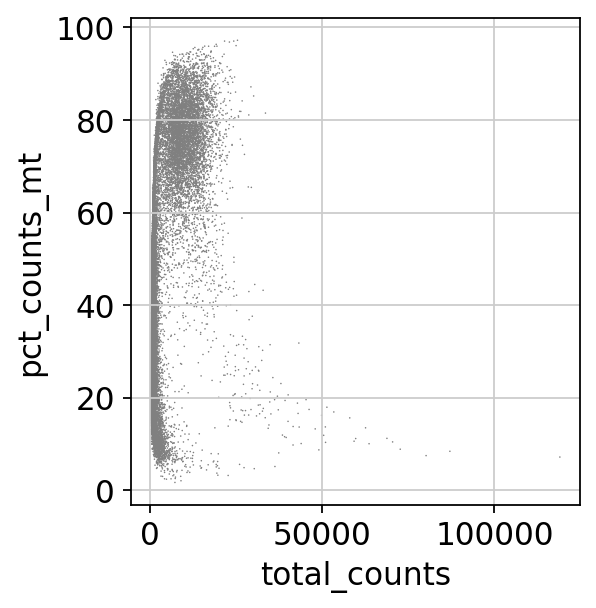

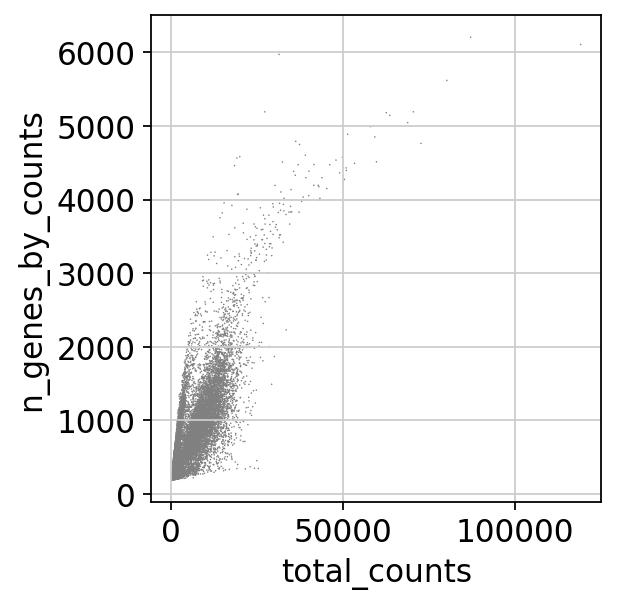

In [12]:
# Scatter plot: total counts vs. percent mitochondrial counts
sc.pl.scatter(adata, x = "total_counts", y = "pct_counts_mt")

# Scatter plot: total counts vs. number of genes detected
sc.pl.scatter(adata, x = "total_counts", y = "n_genes_by_counts")

pct_counts_mt vs. total_counts: This plot shows the relationship between total RNA counts and the percentage of mitochondrial genes. There's a negative correlation, suggesting that cells with higher total counts tend to have a lower percentage of mitochondrial genes.\
n_genes_by_counts vs. total_counts: This plot illustrates the relationship between total RNA counts and the number of genes detected. There's a positive correlation, indicating that cells with more total counts tend to have more genes detected.

In [13]:
# Filter cells with < 2500 detected genes
adata = adata[adata.obs.n_genes_by_counts < 2500, :]

# Filter cells with < 5% mitochondrial counts, make copy
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

Total-count normalization ensures that gene expression counts are comparable across cells by scaling the total counts to a common reference (e.g., 10,000 reads per cell). 

In [14]:
# Normalize total counts to 10,000
sc.pp.normalize_total(adata, target_sum = 1e4)

normalizing counts per cell
    finished (0:00:00)


In [15]:
# Apply log transformation to the gene expression values
# Stabilizes the variance, reduces skewness, and makes the data more suitable for downstream analyses like clustering and visualization
sc.pp.log1p(adata)

In [16]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)

extracting highly variable genes
    Gene indices [ 4742 10228 14731] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [17]:
# Access the highly variable gene information
highly_variable_genes = adata.var['highly_variable']

# Print out the list of highly variable genes
print(highly_variable_genes)

AL627309.1    False
AL669831.5    False
LINC00115     False
FAM41C        False
AL645608.3    False
              ...  
AC007325.4    False
AC007325.2    False
AL354822.1    False
AC004556.1    False
AC240274.1    False
Name: highly_variable, Length: 19864, dtype: bool


In [18]:
# Convert to a pandas DataFrame for easier manipulation
highly_variable_genes_df = pd.DataFrame({
    'gene_id': adata.var_names,
    'highly_variable': highly_variable_genes
})

# Define the file path to save
file_path = '/workspace/highly_variable_genes.csv'

# Save to CSV file
highly_variable_genes_df.to_csv(file_path, index=False)

print(f"Highly variable genes saved to: {file_path}")

Highly variable genes saved to: /workspace/highly_variable_genes.csv


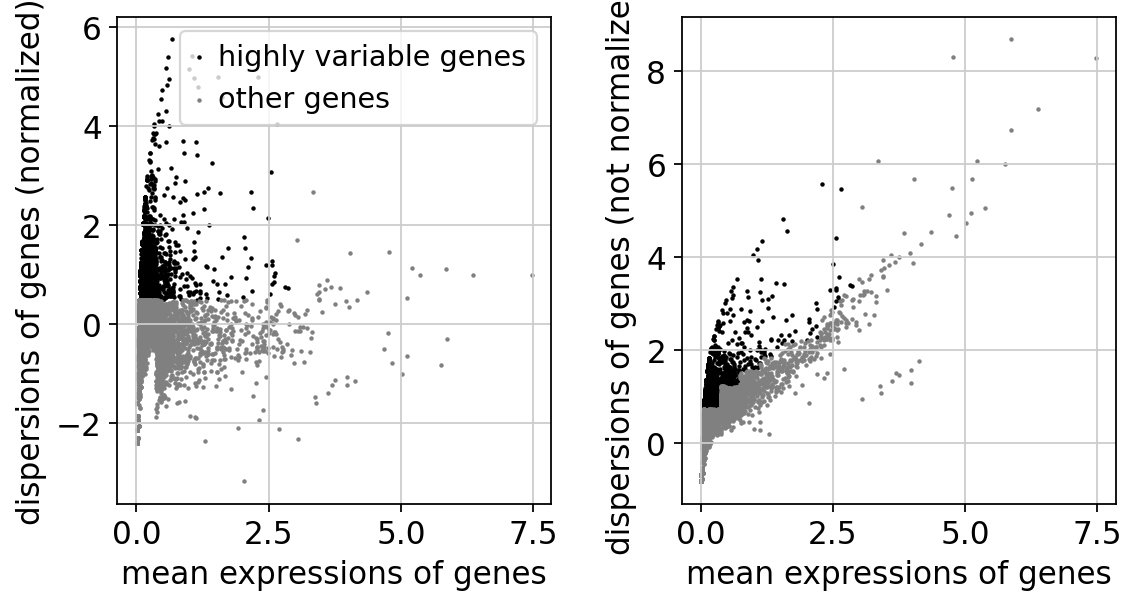

In [19]:
# Visualize highly variable genes
sc.pl.highly_variable_genes(adata)

Normalization Effect: The left plot's normalization reduces the dependency of dispersion on mean expression, making it easier to identify truly variable genes across different expression levels.\
Highly Variable Genes: These are genes that show more variability than expected for their expression level. They're likely to be biologically interesting as they may represent genes involved in cell type differences or cellular processes.\
Technical vs. Biological Variability: Genes with very low mean expression but high dispersion (bottom left of plots) might represent technical noise rather than biological signal.\
Gene Distribution: Most genes cluster at lower mean expression levels, with fewer genes showing high expression levels.\
Identification of Variable Genes: The method used here helps distinguish genes that are variable due to biological factors from those that appear variable due to technical aspects of single-cell sequencing.

In [20]:
# Set raw data to preserve original counts
adata.raw = adata

In [21]:
# Subset to highly variable genes
adata = adata[:, adata.var.highly_variable]

In [22]:
# Regress out unwanted variables
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:04)


In [23]:
# Scale each gene to unit variance. 
# Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value = 10)

    ... clipping at max_value 10


## Principal component analysis

In [24]:
# Perform PCA analysis using the ARPACK solver
# The ARPACK (ARnoldi PACKage) library is commonly used for PCA
# ARPACK is suitable for datasets where the number of genes (features) can be much larger than the number of cells (samples)
# Since scRNA-seq data matrices are often sparse (many zeros), ARPACK's efficiency and handling of sparse matrices make it a suitable choice
sc.tl.pca(adata, svd_solver = "arpack")

computing PCA
    with n_comps=34
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


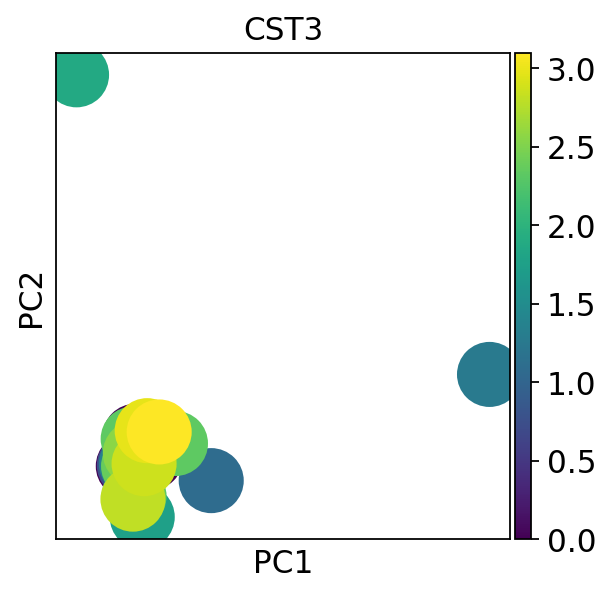

In [25]:
# Visualize PCA results, coloring cells based on expression of "CST3"
sc.pl.pca(adata, color = "CST3")

It shows data points projected onto the first two principal components (PC1 and PC2).\
The color of each point represents the expression level of the CST3 gene, with the scale ranging from 0 (purple) to 3 (yellow).\
We can see clusters of points with varying CST3 expression levels, suggesting that CST3 expression may be correlated with the patterns captured by the first two principal components.

CST3 expression seems to vary across different clusters in the PCA plot, indicating it may be an important factor in distinguishing cell populations or conditions.

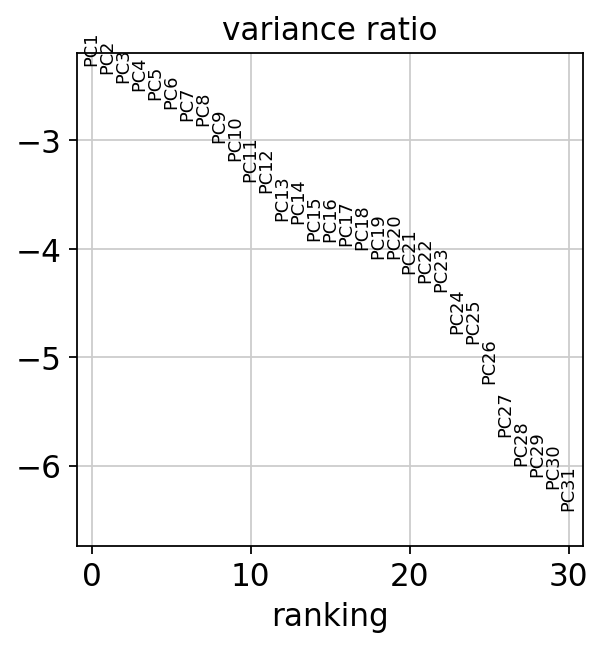

In [26]:
# Visualize variance ratio explained by each principal component
sc.pl.pca_variance_ratio(adata, log = True)

The x-axis represents the ranking of principal components.\
The y-axis shows the log of the variance ratio explained by each component.\
The downward trend indicates that earlier principal components explain more variance in the data.\
The steep initial decline suggests that the first few components capture a significant portion of the dataset's variability.

The variance ratio plot shows a typical "elbow" shape, suggesting that a small number of principal components might be sufficient to explain most of the variance in the data.\
The use of log scale for the variance ratio emphasizes the differences between components, especially for those explaining less variance.

In [27]:
# Write the processed AnnData object to the file
adata.write(results_file)

In [28]:
# Display the processed AnnData object
adata

AnnData object with n_obs × n_vars = 35 × 2170
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [29]:
# Extract PCA coordinates and explained variance ratio
pca_coords = pd.DataFrame(adata.obsm['X_pca'], columns=[f'PC{i+1}' for i in range(adata.obsm['X_pca'].shape[1])])
explained_variance_ratio = pd.Series(adata.uns['pca']['variance_ratio'], name='Explained_Variance_Ratio')

# Save PCA coordinates to CSV
pca_coords.to_csv("pca_coordinates.csv", index=False)

# Save explained variance ratio to CSV
explained_variance_ratio.to_csv("explained_variance_ratio.csv", index=False)

# Optionally, print the first few rows of the extracted dataframes
print("PCA Coordinates:\n", pca_coords.head())
print("\nExplained Variance Ratio:\n", explained_variance_ratio)

PCA Coordinates:
         PC1       PC2       PC3        PC4        PC5        PC6       PC7  \
0 -5.483018 -4.586652 -0.261113  -3.611581  -1.631968  -5.110290 -2.344123   
1 -4.659883 -5.274722 -0.420980  -4.560738  -1.154238  -5.500363 -2.095540   
2 -0.197456 -1.089758 -1.629449  -3.075751   0.199436  -0.214425  0.311282   
3 -5.000811 -4.255180  6.290462 -29.771156 -37.956341  45.204609  1.701687   
4 -5.723164 -4.740397 -0.764462  -3.289322  -1.285805  -3.996992 -2.252659   

        PC8        PC9      PC10  ...      PC25       PC26       PC27  \
0 -0.951364  -9.161250  4.929096  ...  1.625456  -3.205229  -0.501703   
1 -1.199185 -11.327690  6.053001  ...  2.143788  -6.354215   2.106971   
2 -3.939877  -8.169353 -3.674396  ... -1.743410  -2.550876  11.977777   
3 -1.564119   8.133906 -6.763916  ... -0.268815   0.361476  -0.159300   
4 -0.714361  -9.421838  4.687881  ...  2.650220  14.703515   3.858626   

       PC28      PC29      PC30      PC31      PC32          PC33  \
0 -5.

## Computing the neighborhood graph

In [33]:
# Re-run PCA with adjusted `n_comps` using 'randomized' solver
# arpack cannot compute more components than the lesser of the number of samples and features
sc.tl.pca(adata, svd_solver="randomized", n_comps = 35)

# Compute neighborhood graph based on PCA space with 10 neighbors and 35 principal components
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 35)

computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    with n_comps=35
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 35
    computed neighbors (0:00:00)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [35]:
# Compute neighborhood graph based on PCA space with 10 neighbors and 40 principal components
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 35)

computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors
    using 'X_pca' with n_pcs = 35
    computed neighbors (0:00:00)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


## Embedding the neighborhood graph

#### Perform Leiden clustering

In [37]:
# Perform clustering using Leiden algorithm
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/tmp/ipykernel_46/2056272130.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


In [38]:
# Perform PAGA analysis
sc.tl.paga(adata)
sc.pl.paga(adata, plot = False)  # remove `plot=False` if you want to see the coarse-grained graph

# Compute UMAP embedding based on PAGA initialization
sc.tl.umap(adata, init_pos = 'paga')

running PAGA
        initialized `.distances` `.connectivities` 
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP


  0%|          | 0/500 [00:00<?, ?it/s]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


In [39]:
sc.tl.umap(adata)

computing UMAP


  0%|          | 0/500 [00:00<?, ?it/s]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


--> added 'pos', the PAGA positions (adata.uns['paga'])


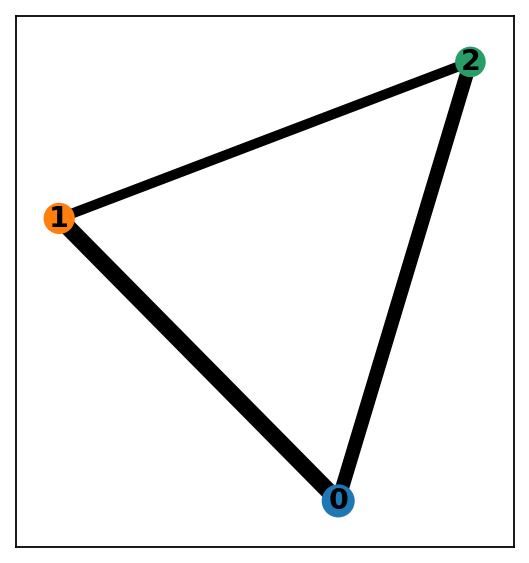

In [40]:
sc.pl.paga(adata, plot = True)

In [44]:
# Access the PCA results
pcs = adata.obsm['X_pca']

# Access the loadings of genes on each PC
loadings = adata.varm['PCs']

# Define a function to get top genes for each PC
def get_top_genes_for_pc(pc_index, n_top_genes=10):
    pc_loadings = loadings[:, pc_index]
    sorted_genes_indices = pc_loadings.argsort()[::-1]  # Sort in descending order of loading values
    top_genes_indices = sorted_genes_indices[:n_top_genes]
    top_genes_names = adata.var_names[top_genes_indices]
    top_genes_loadings = pc_loadings[top_genes_indices]
    return pd.DataFrame({
        'Gene': top_genes_names,
        f'PC{pc_index + 1}_Loading': top_genes_loadings
    })

# Get top genes for the first three PCs
top_genes_pc1 = get_top_genes_for_pc(0)
top_genes_pc2 = get_top_genes_for_pc(1)
top_genes_pc3 = get_top_genes_for_pc(2)

# Print or further analyze the top genes for each PC
print("Top genes for PC1:")
print(top_genes_pc1)

print("\nTop genes for PC2:")
print(top_genes_pc2)

print("\nTop genes for PC3:")
print(top_genes_pc3)

Top genes for PC1:
        Gene  PC1_Loading
0    SLCO2A1     0.065233
1      P4HTM     0.065233
2      IFI27     0.065233
3  LINC01137     0.065233
4    CLEC14A     0.065233
5       HEG1     0.065233
6      NOVA1     0.065233
7      ADCY4     0.065233
8   MARCKSL1     0.065233
9     ARGLU1     0.065233

Top genes for PC2:
      Gene  PC2_Loading
0  DNAJC11     0.067565
1   SLC6A1     0.067565
2   TARBP2     0.067565
3  ZNF354A     0.067565
4     PAK1     0.067565
5    SYCE1     0.067565
6     SPI1     0.067565
7      FTO     0.067565
8   ZSCAN9     0.067565
9   TRIM10     0.067565

Top genes for PC3:
         Gene  PC3_Loading
0        MFN2     0.056061
1  AC005225.2     0.056061
2      ZNF609     0.056061
3        TLK2     0.056061
4       BCAR3     0.056061
5        CLP1     0.056061
6       CPSF7     0.056061
7     JAKMIP2     0.056061
8       JMJD6     0.056061
9     TRAPPC4     0.056061


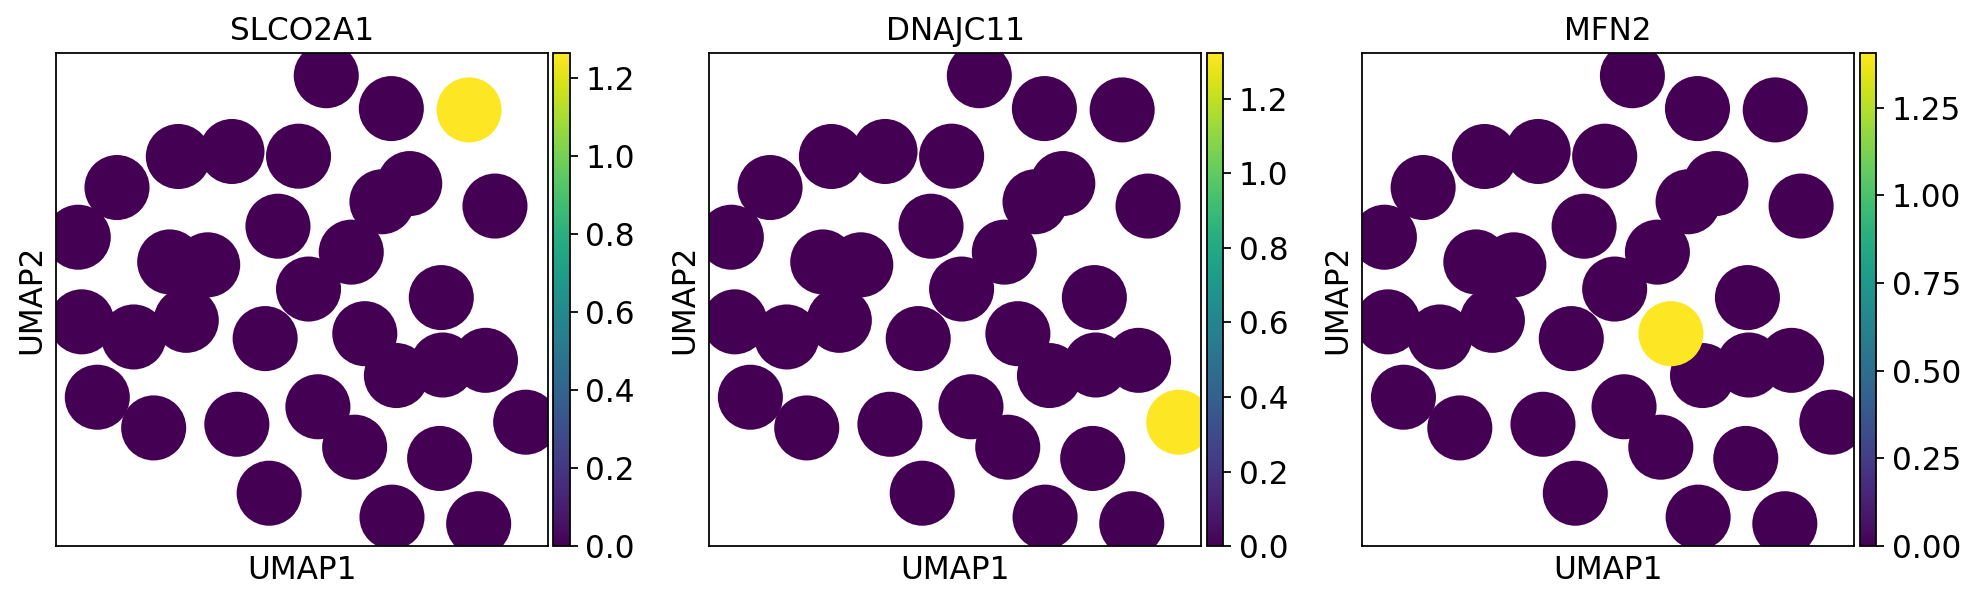

In [45]:
sc.pl.umap(adata, color=["SLCO2A1", "DNAJC11", "MFN2"])

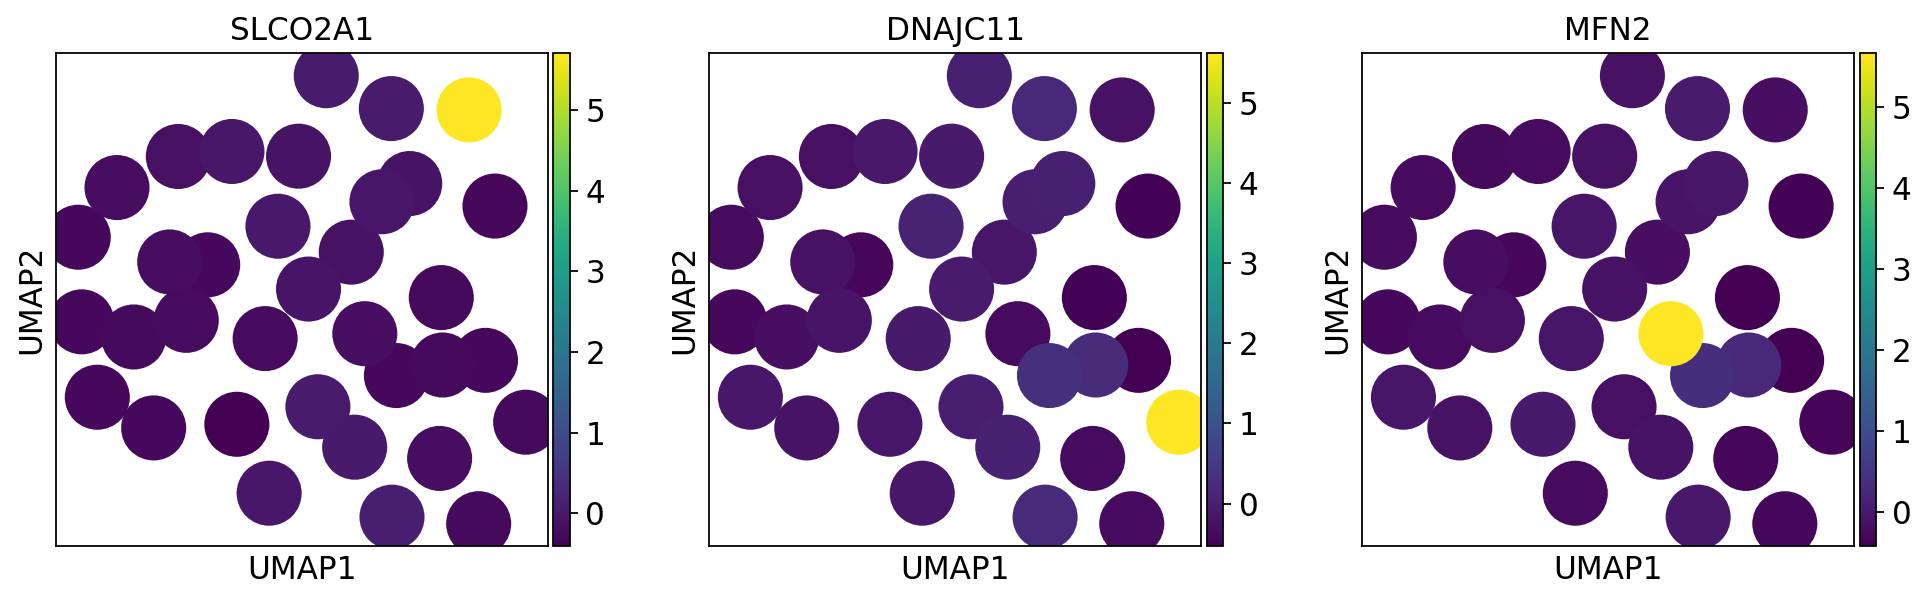

In [46]:
sc.pl.umap(adata, color=["SLCO2A1", "DNAJC11", "MFN2"], use_raw=False)

## Clustering the neighborhood graph

In [47]:
# Perform Leiden clustering on the AnnData object with specific parameters
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


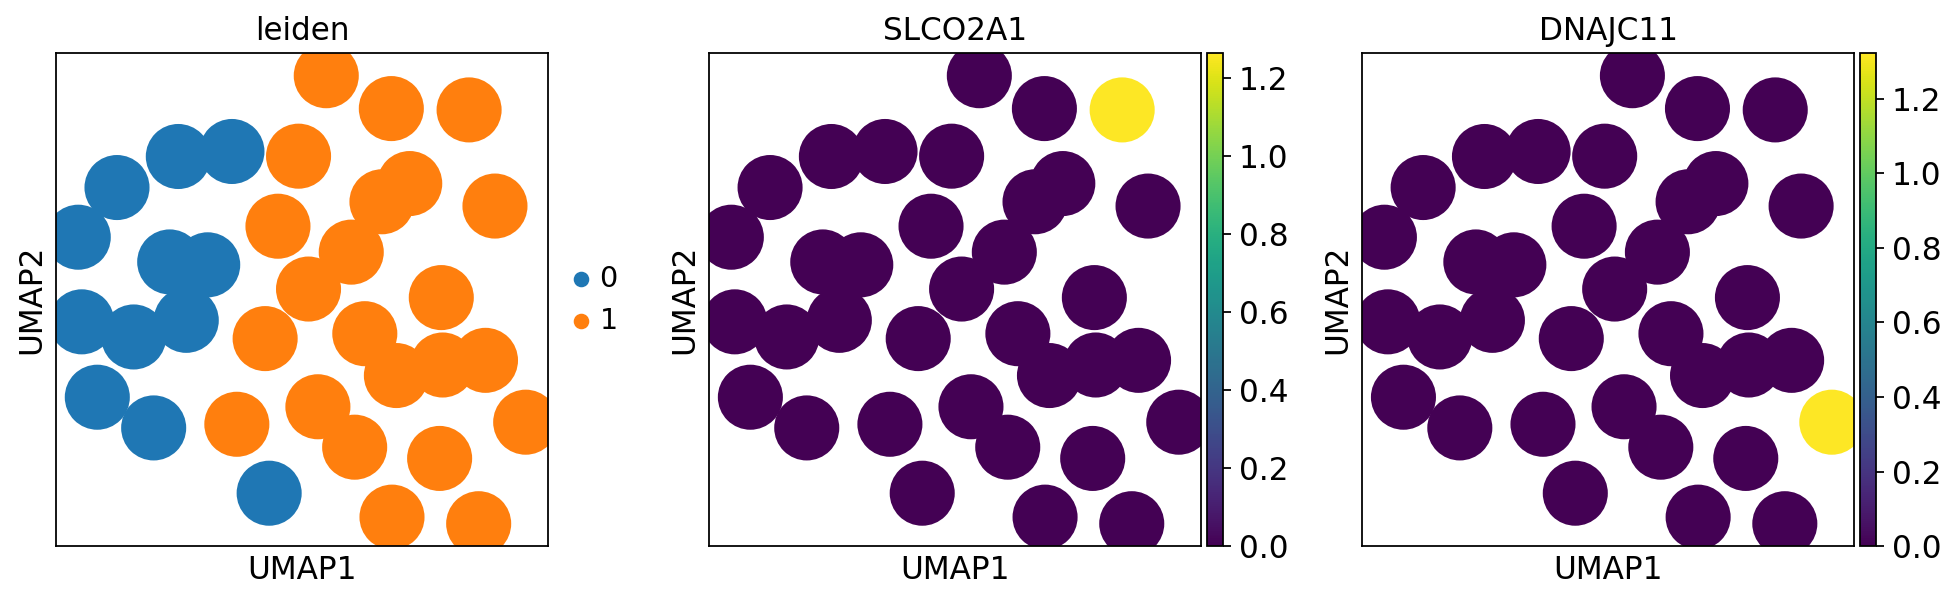

In [48]:
sc.pl.umap(adata, color=["leiden", "SLCO2A1", "DNAJC11"])

In [49]:
# Write the processed AnnData object to the specified file
adata.write(results_file)

## Finding marker genes

ranking genes
    consider 'leiden' groups:
    with sizes: [12 23]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


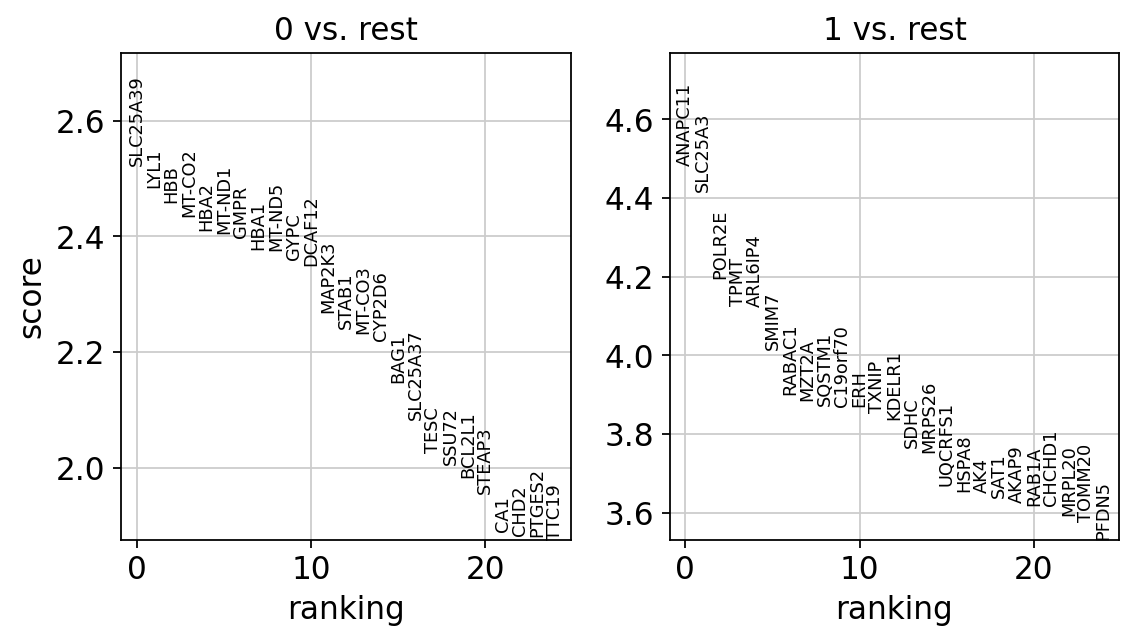

In [50]:
# Perform differential expression analysis (t-test) to identify marker genes for each cluster defined by Leiden clustering
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")

# Visualize the top 25 marker genes for each cluster
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [51]:
# Reduce the verbosity of Scanpy output to level 2
sc.settings.verbosity = 2

ranking genes
    finished (0:00:00)


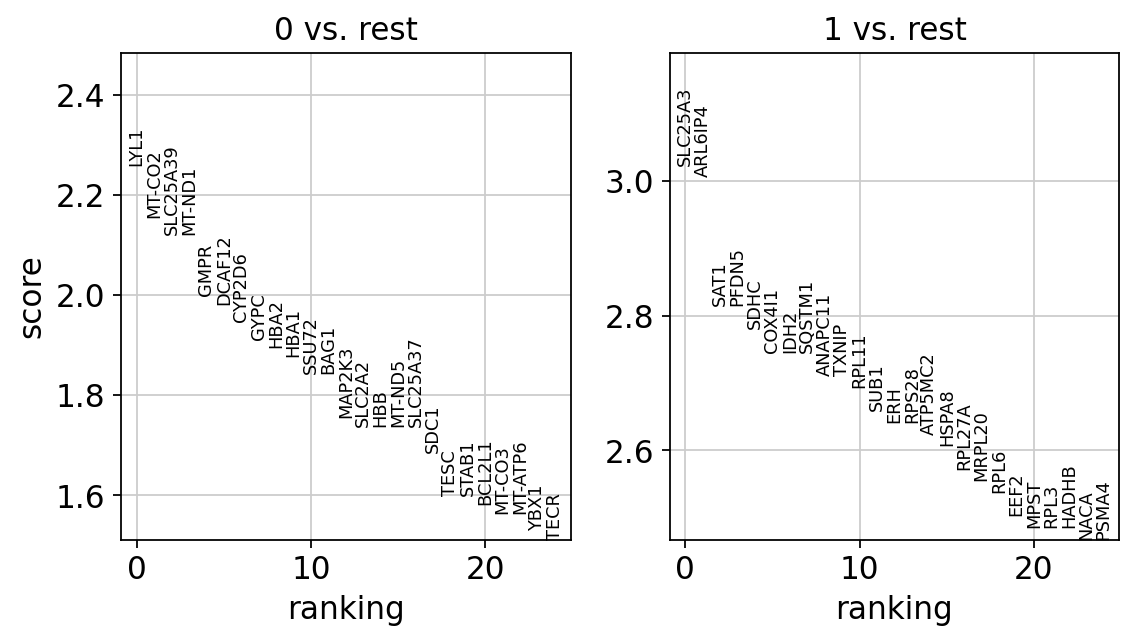

In [52]:
# Perform differential expression analysis using the Wilcoxon rank-sum test
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")

# Visualize the top differentially expressed genes per cluster
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [53]:
# Write the processed AnnData object to the specified file
adata.write(results_file)

ranking genes
    finished (0:00:01)


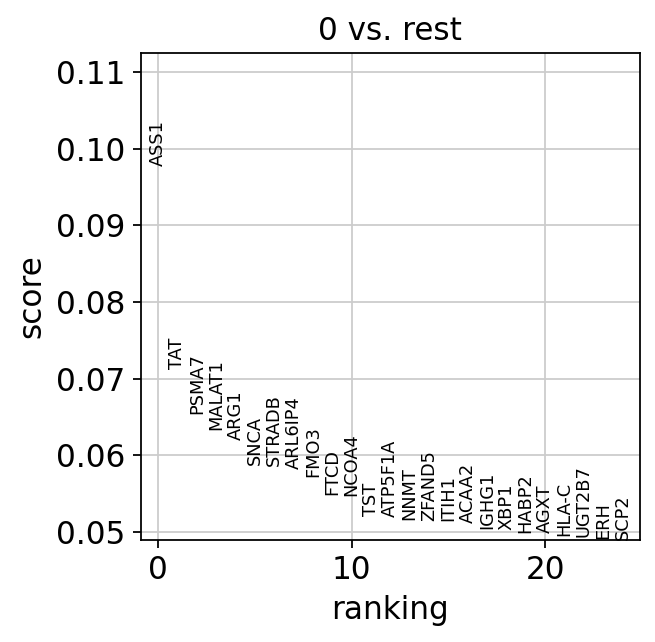

In [54]:
# Perform differential expression analysis using logistic regression
sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000)

# Visualize the results of the differential expression analysis
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [55]:
adata = sc.read(results_file)

In [56]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

,0,1
0,LYL1,SLC25A3
1,MT-CO2,ARL6IP4
2,SLC25A39,SAT1
3,MT-ND1,PFDN5
4,GMPR,SDHC


In [57]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

,0_n,0_p,1_n,1_p
0,LYL1,0.023889,SLC25A3,0.002499
1,MT-CO2,0.031189,ARL6IP4,0.002646
2,SLC25A39,0.034015,SAT1,0.004879
3,MT-ND1,0.034015,PFDN5,0.004879
4,GMPR,0.045688,SDHC,0.005433


ranking genes
    finished (0:00:00)


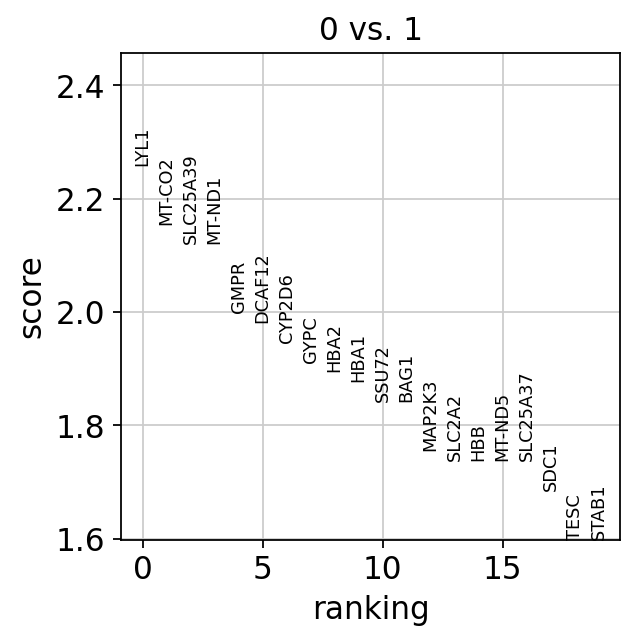

In [58]:
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/__init__.py:1303: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


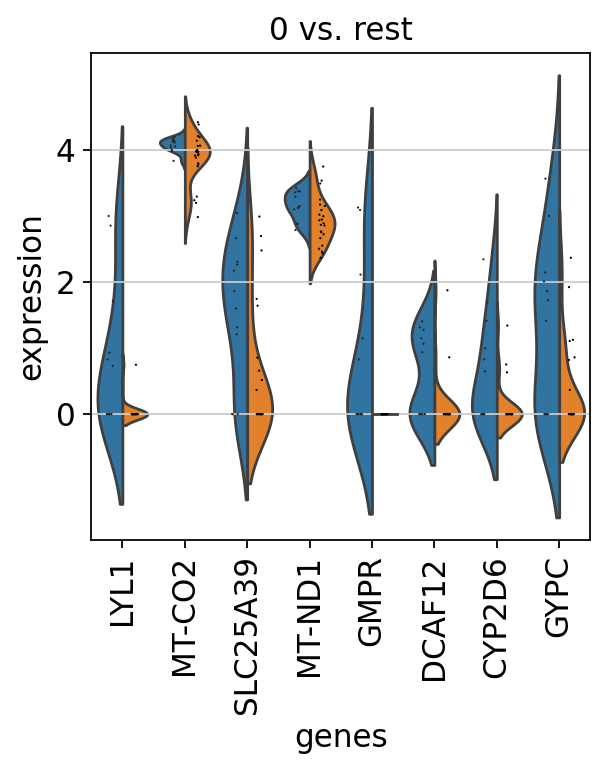

In [60]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

In [61]:
adata = sc.read(results_file)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/__init__.py:1303: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


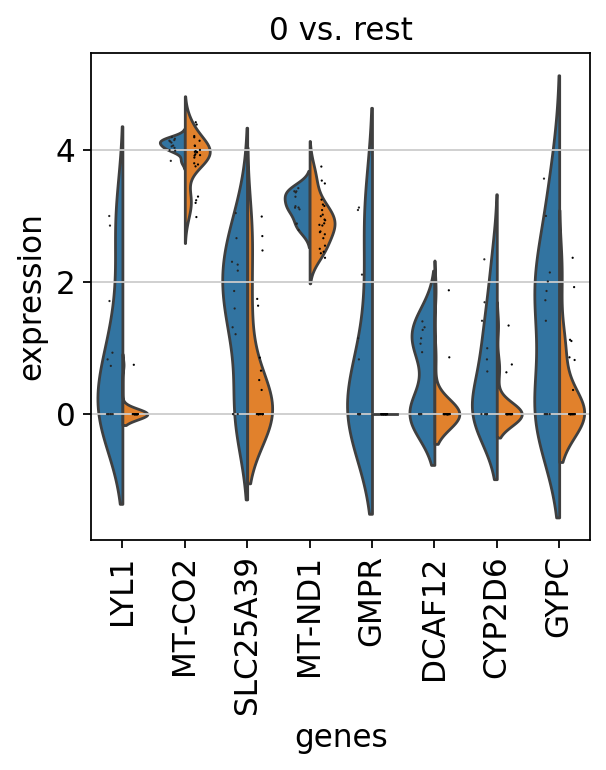

In [62]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

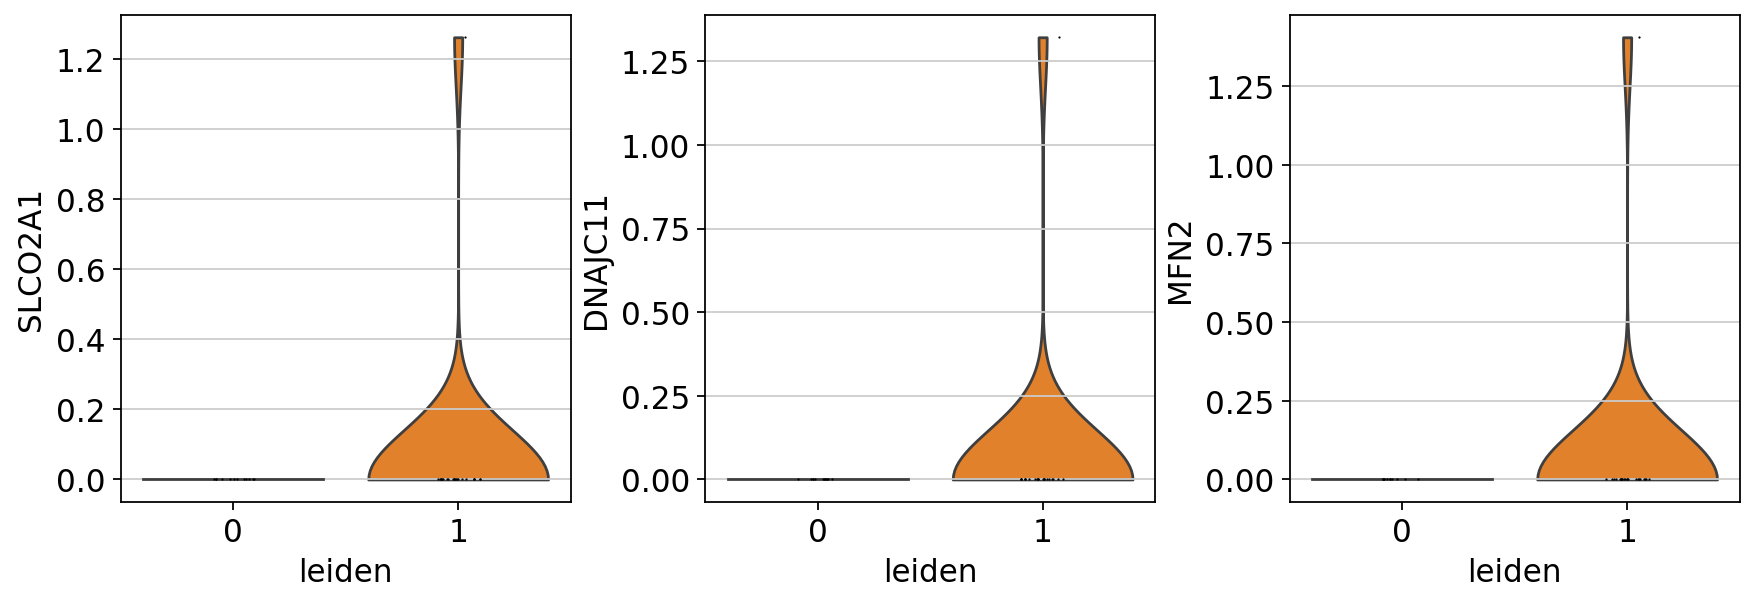

In [63]:
sc.pl.violin(adata, ["SLCO2A1", "DNAJC11", "MFN2"], groupby="leiden")

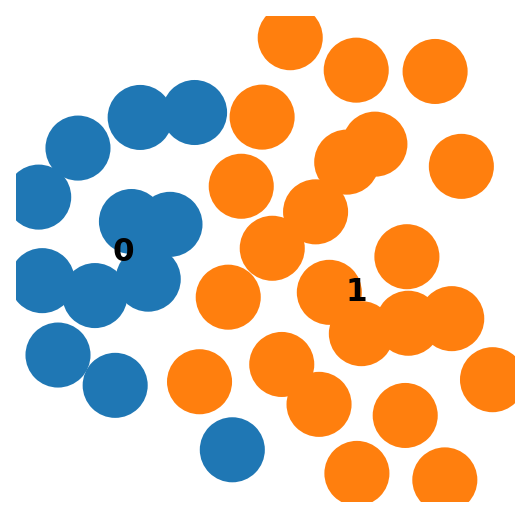

In [64]:
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)

In [65]:
adata

AnnData object with n_obs × n_vars = 35 × 2170
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [66]:
# `compression='gzip'` saves disk space, and slightly slows down writing and subsequent reading
adata.write(results_file, compression="gzip")

In [68]:
adata.raw.to_adata().write("./write/GSM7802682_withoutX.h5ad")